In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.metrics import log_loss, accuracy_score
import optuna
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LogisticRegression




C:\Users\leonc\AppData\Roaming\Python\Python314\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Load data
data = pd.read_csv("Final/Train.csv")

X = data.drop(columns=["result"]).values
y = data["result"].astype(int).values

scaler = StandardScaler() # Standardize features Neural networks perform better with standardized data
X = scaler.fit_transform(X)

X_torch = torch.tensor(X, dtype=torch.float32) # Convert to PyTorch tensor.. Mlp required
y_torch = torch.tensor(y, dtype=torch.float32).unsqueeze(1)

In [3]:
# Calibration and evaluation functions , notice NAN handling is repeated, they are needed later for scaling so they are removed 
# in individual functions then from the orginal model returns

# 1) log loss, accuracy, error rate - we use log loss and accuracy(error rate) primary metrics, also returns number of NANs and fraction of NANs
def compute_basic_metrics(y_out, y_prob, threshold=0.5):
    y_out = np.asarray(y_out).astype(int)
    y_prob = np.asarray(y_prob).astype(float)

    # Nans happen with timeseries cross-validation for first rows
    m = ~np.isnan(y_prob)
    y_out = y_out[m]
    y_prob = y_prob[m]
    ll = log_loss(y_out, y_prob)
    acc = accuracy_score(y_out, (y_prob >= threshold).astype(int))
    err = 1.0 - acc
    return ll, acc, err, m.sum(), m.mean()

# Expected Calibration Error (ECE): Good way of measuring probability calibration (check readme for betetr description)
def expected_calibration_error(y_out, y_prob, n_bins=10, return_bins=False):
    y_out = np.asarray(y_out).astype(int)
    y_prob = np.asarray(y_prob).astype(float)
    m = ~np.isnan(y_prob)
    y_out = y_out[m]
    y_prob = y_prob[m]
    bin_edges = np.linspace(0.0, 1.0, n_bins + 1)
    bin_ids = np.digitize(y_prob, bin_edges, right=True) - 1
    bin_ids = np.clip(bin_ids, 0, n_bins - 1)
    acc = np.full(n_bins, np.nan)
    conf = np.full(n_bins, np.nan)
    counts = np.zeros(n_bins, dtype=int)
    n = len(y_out)
    ece = 0.0

    for b in range(n_bins):
        idx = bin_ids == b
        counts[b] = idx.sum()
        if counts[b] > 0:
            acc[b] = y_out[idx].mean()
            conf[b] = y_prob[idx].mean()
            ece += (counts[b] / n) * abs(acc[b] - conf[b])
    if return_bins:
        return ece, acc, conf, counts, bin_edges
    return ece

#Plot reliability diagram and a probability histogram 
def reliability_diagram(y_out,y_prob,n_bins=10,hist_bins=30,title="Reliability Diagram"):
    
    ece, acc, conf, counts, bin_edges = expected_calibration_error(y_out, y_prob, n_bins=n_bins, return_bins=True)
    centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    width = (bin_edges[1] - bin_edges[0]) * 0.9
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 7),gridspec_kw={"height_ratios": [3, 2]})

    #reliability diagram
    ax1.plot([0, 1], [0, 1], linestyle="--", linewidth=2, label="Perfect calibration")
    ax1.bar(centers, np.nan_to_num(acc, nan=0.0), width=width, label="Accuracy")
    bottom = np.nan_to_num(np.minimum(acc, conf), nan=0.0)
    height = np.nan_to_num(np.abs(acc - conf), nan=0.0)
    ax1.bar(centers, height, bottom=bottom, width=width, hatch="xx", alpha=0.35,color="tab:red", label="Gap")
    ax1.set_xlim(0, 1)
    ax1.set_ylim(0, 1)
    ax1.set_xlabel("Confidence")
    ax1.set_ylabel("Accuracy")
    ax1.set_title(title)

    # Display ECE in percentage points
    ax1.text(0.62, 0.06, f"ECE={ece*100:.2f}",
        transform=ax1.transAxes,
        bbox=dict(boxstyle="round", facecolor="white", alpha=0.85))
    ax1.legend(loc="upper left")

    #probability histogram 
    ax2.hist(y_prob, bins=hist_bins)
    ax2.set_xlim(0, 1)
    ax2.set_xlabel("Predicted probability")
    ax2.set_ylabel("Count")
    ax2.set_title("Predicted probability distribution")
    plt.tight_layout()
    plt.show()

    return ece



In [4]:

# Define MLP model with TimeSeriesSplit cross-validation and selectable hyperparameters

def mlp(
    X, y,
    n_splits=5,
    n_epochs=10,
    batch_size=512,
    lr=1e-3,
    weight_decay=1e-5,
    dropout=0.0,
    seed=42,
    max_norm=None,
    return_logits=False,):
    torch.manual_seed(seed)
    np.random.seed(seed)

    tscv = TimeSeriesSplit(n_splits=n_splits) # TimeSeriesSplit for data leakage prevention
    oof = np.full(len(y), np.nan, dtype=float)
    oof_logits = np.full(len(y), np.nan, dtype=float)

    # Model arhitecture + dropout toggle
    def arch(input_dim):
        layers = [
            nn.Linear(input_dim, 256), nn.ReLU()
        ]
        if dropout > 0:
            layers.append(nn.Dropout(dropout))

        layers += [nn.Linear(256, 256), nn.ReLU()]
        if dropout > 0:
            layers.append(nn.Dropout(dropout))

        layers += [nn.Linear(256, 256), nn.ReLU()]
        if dropout > 0:
            layers.append(nn.Dropout(dropout))

        layers += [nn.Linear(256, 256), nn.ReLU()]
        if dropout > 0:
            layers.append(nn.Dropout(dropout))

        layers += [nn.Linear(256, 1)]
        model = nn.Sequential(*layers)
        return model

    for fold, (train_idx, test_idx) in enumerate(tscv.split(X), start=1):
        X_train, y_train = X[train_idx], y[train_idx]
        X_test, y_test = X[test_idx], y[test_idx]

        # Fold scaling for leakage
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)

        Xtr = torch.tensor(X_train, dtype=torch.float32)
        ytr = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
        Xte = torch.tensor(X_test, dtype=torch.float32)

        model = arch(input_dim=X.shape[1])
        criterion = nn.BCEWithLogitsLoss() # Binary Cross Entropy with Logits Loss  more stable than sigmoid manually 
        optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

        dataset = torch.utils.data.TensorDataset(Xtr, ytr)
        loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

        model.train()
        for epoch in range(n_epochs):
            for xb, yb in loader:
                optimizer.zero_grad()
                logits = model(xb)
                loss = criterion(logits, yb)
                loss.backward()
                optimizer.step()

        model.eval()
        with torch.no_grad():
            logits = model(Xte).squeeze(1).cpu().numpy()
            probs = 1.0 / (1.0 + np.exp(-logits))  #convert to probs

        oof[test_idx] = probs
        if return_logits:
            oof_logits[test_idx] = logits

    if return_logits:
        return oof, oof_logits
    return oof

# Function to create for log loss or error rate optimization using optuna optimization
def opt(X, y, optimize_for="logloss", n_splits_tune=3, seed=42):
    
    def ranges(trial):
        lr = trial.suggest_float("lr", 1e-4, 5e-3, log=True)
        weight_decay = trial.suggest_float("weight_decay", 1e-7, 1e-3, log=True)
        dropout = trial.suggest_float("dropout", 0.0, 0.5)
        batch_size = trial.suggest_categorical("batch_size", [256, 512, 1024])
        n_epochs = trial.suggest_int("n_epochs", 6, 20)

        oof = mlp(
            X, y,
            n_splits=n_splits_tune,
            n_epochs=n_epochs,
            batch_size=batch_size,
            lr=lr,
            weight_decay=weight_decay,
            dropout=dropout,
            max_norm=None,
            seed=seed)

        m = ~np.isnan(oof)
        if optimize_for == "logloss":
            return log_loss(y[m], oof[m])
        elif optimize_for == "error":
            preds = (oof[m] >= 0.5).astype(int)
            return 1.0 - accuracy_score(y[m], preds)  

    return ranges

#function to run two optuna simulations, one for log loss and one for error rate
def sim_opt(X, y, n_trials=40, n_splits_tune=3, seed=42):
    #log loss
    study_ll = optuna.create_study(direction="minimize", sampler=optuna.samplers.TPESampler(seed=seed))
    study_ll.optimize(opt(X, y, optimize_for="logloss", n_splits_tune=n_splits_tune, seed=seed),
                      n_trials=n_trials)

    #error rate
    study_err = optuna.create_study(direction="minimize", sampler=optuna.samplers.TPESampler(seed=seed))
    study_err.optimize(opt(X, y, optimize_for="error", n_splits_tune=n_splits_tune, seed=seed),
                       n_trials=n_trials)

    return study_ll, study_err

# evaluate models with best hyperparameters found by optuna
def evaluate(X, y, best_params, n_splits_eval=5, seed=42, return_logits=False):
    out = mlp(X, y,
        n_splits=n_splits_eval,
        n_epochs=best_params["n_epochs"],
        batch_size=best_params["batch_size"],
        lr=best_params["lr"],
        weight_decay=best_params["weight_decay"],
        dropout=best_params["dropout"],
        seed=seed,
        return_logits=return_logits)

    if return_logits:
        oof_probs, oof_logits = out
    else:
        oof_probs = out

    m = ~np.isnan(oof_probs)
    ll = log_loss(y[m], oof_probs[m])
    acc = accuracy_score(y[m], (oof_probs[m] >= 0.5).astype(int))
    err = 1.0 - acc
    ece = expected_calibration_error(y[m], oof_probs[m], n_bins=10)

    print(f"OOF coverage: {m.mean()} | NaNs: {np.isnan(oof_probs).sum()} / {len(oof_probs)}")
    print(f"OOF log loss: {ll}")
    print(f"OOF accuracy: {acc}")
    print(f"OOF error rate: {err}")
    print(f"OOF ECE (fraction): {ece} | % points: {ece*100}")
    if return_logits:
        return oof_probs, oof_logits
    return oof_probs

In [5]:
study_ll, study_err = sim_opt(X, y, n_trials=40, n_splits_tune=3, seed=42)
print("Best (logloss) params:", study_ll.best_params, "best value:", study_ll.best_value)
print("Best (error)   params:", study_err.best_params, "best value:", study_err.best_value)

[I 2026-01-09 20:13:59,058] A new study created in memory with name: no-name-4361d424-6155-47b0-92ef-a14c3fbc5c64
[I 2026-01-09 20:14:33,179] Trial 0 finished with value: 0.5948253410179697 and parameters: {'lr': 0.00043284502212938834, 'weight_decay': 0.0006351221010640698, 'dropout': 0.36599697090570255, 'batch_size': 256, 'n_epochs': 6}. Best is trial 0 with value: 0.5948253410179697.
[I 2026-01-09 20:15:11,634] Trial 1 finished with value: 0.598623565713596 and parameters: {'lr': 0.0029621516588303515, 'weight_decay': 2.5378155082656606e-05, 'dropout': 0.35403628889802274, 'batch_size': 512, 'n_epochs': 9}. Best is trial 0 with value: 0.5948253410179697.
[I 2026-01-09 20:16:25,407] Trial 2 finished with value: 0.6039946490558122 and parameters: {'lr': 0.00020366442026830908, 'weight_decay': 5.415244119402535e-07, 'dropout': 0.15212112147976886, 'batch_size': 256, 'n_epochs': 15}. Best is trial 0 with value: 0.5948253410179697.
[I 2026-01-09 20:17:19,631] Trial 3 finished with value

Best (logloss) params: {'lr': 0.000533853641534584, 'weight_decay': 4.398017180584654e-06, 'dropout': 0.42515080111029613, 'batch_size': 256, 'n_epochs': 8} best value: 0.5940372049688666
Best (error)   params: {'lr': 0.00018232149103426372, 'weight_decay': 2.5161801333744398e-06, 'dropout': 0.45477228794276553, 'batch_size': 256, 'n_epochs': 13} best value: 0.3236535461968988


In [6]:
# logits useful for calibration plots later hence done now to save time
print("Evaluate best logloss-tuned MLP")
oof_ll, logit_ll = evaluate(X, y, study_ll.best_params, n_splits_eval=5, seed=42, return_logits=True)
print("Evaluate best error-tunedMLP")
oof_err, logit_err = evaluate(X, y, study_err.best_params, n_splits_eval=5, seed=42, return_logits=True)

Evaluate best logloss-tuned MLP
OOF coverage: 0.8333333333333334 | NaNs: 9688 / 58128
OOF log loss: 0.5938758677656654
OOF accuracy: 0.6760115606936417
OOF error rate: 0.32398843930635834
OOF ECE (fraction): 0.011131471961005718 | % points: 1.113147196100572
Evaluate best error-tunedMLP
OOF coverage: 0.8333333333333334 | NaNs: 9688 / 58128
OOF log loss: 0.5935975258954341
OOF accuracy: 0.6764450867052023
OOF error rate: 0.3235549132947977
OOF ECE (fraction): 0.017889621195509867 | % points: 1.7889621195509866


# Droput vs ECE/Log-loss

In [ ]:

#dropout grid
dropouts = np.array([0.0, 0.05, 0.10, 0.15, 0.20, 0.25, 0.30, 0.40, 0.50])

ece_vals = []
ll_vals = []
acc_vals = []
err_vals = []

for d in dropouts:
    oof = mlp(
        X, y,
        n_splits=5,                       
        n_epochs=study_ll.best_params["n_epochs"],
        batch_size=study_ll.best_params["batch_size"],
        lr=study_ll.best_params["lr"],
        weight_decay=study_ll.best_params["weight_decay"],
        dropout=float(d),
        seed=42
    )

    mask = ~np.isnan(oof)
    ece = expected_calibration_error(y[mask], oof[mask], n_bins=10)
    ll = log_loss(y[mask], oof[mask])
    acc = accuracy_score(y[mask], (oof[mask] >= 0.5).astype(int))
    err = 1.0 - acc

    ece_vals.append(ece)
    ll_vals.append(ll)
    acc_vals.append(acc)
    err_vals.append(err)

    print(f"dropout={d:.4f} | ECE={ece*100:.4f}% | logloss={ll:.4f} | acc={acc:.4f} | err={err:.4f}")
ece_vals = np.array(ece_vals)
ll_vals = np.array(ll_vals)
acc_vals = np.array(acc_vals)
err_vals = np.array(err_vals)



dropout=0.0000 | ECE=4.6248% | logloss=0.6111 | acc=0.6689 | err=0.3311
dropout=0.0500 | ECE=3.3638% | logloss=0.6073 | acc=0.6667 | err=0.3333
dropout=0.1000 | ECE=2.8526% | logloss=0.6023 | acc=0.6728 | err=0.3272
dropout=0.1500 | ECE=2.4940% | logloss=0.5999 | acc=0.6739 | err=0.3261
dropout=0.2000 | ECE=2.4939% | logloss=0.5987 | acc=0.6738 | err=0.3262
dropout=0.2500 | ECE=2.2491% | logloss=0.5975 | acc=0.6750 | err=0.3250
dropout=0.3000 | ECE=1.9931% | logloss=0.5961 | acc=0.6747 | err=0.3253
dropout=0.4000 | ECE=1.3602% | logloss=0.5944 | acc=0.6755 | err=0.3245
dropout=0.5000 | ECE=0.7958% | logloss=0.5929 | acc=0.6758 | err=0.3242


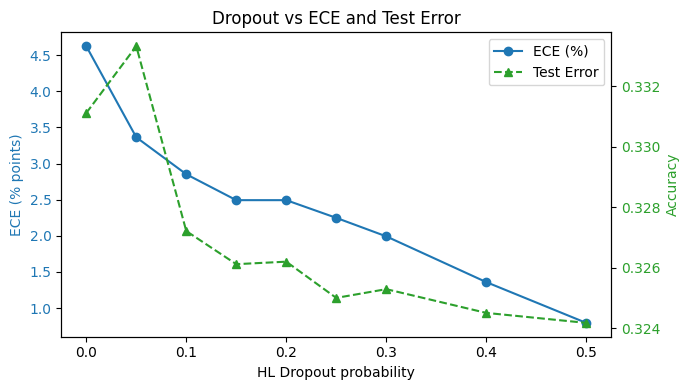

In [8]:

fig, ax1 = plt.subplots(figsize=(7, 4))

ax1.plot(
    dropouts,
    ece_vals * 100,
    marker="o",
    color="tab:blue",
    label="ECE (%)")
ax1.set_xlabel("HL Dropout probability")
ax1.set_ylabel("ECE (% points)", color="tab:blue")
ax1.tick_params(axis="y", labelcolor="tab:blue")

ax2 = ax1.twinx()
ax2.plot(
    dropouts,
    err_vals,
    marker="^",
    linestyle="--",
    color="tab:green",
    label="Test Error")
ax2.set_ylabel("Accuracy", color="tab:green")
ax2.tick_params(axis="y", labelcolor="tab:green")

lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc="best")

plt.title("Dropout vs ECE and Test Error")
plt.tight_layout()
plt.show()


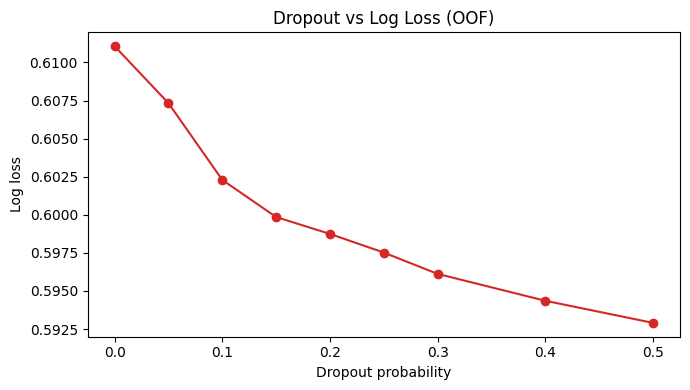

In [9]:
plt.figure(figsize=(7, 4))
plt.plot(
    dropouts,
    ll_vals,
    marker="o",
    linestyle="-",
    color="tab:red")

plt.xlabel("Dropout probability")
plt.ylabel("Log loss")
plt.title("Dropout vs Log Loss (OOF)")
plt.tight_layout()
plt.show()


In [ ]:
#weight grid
weights = np.array([0.0,1e-7,3e-7,1e-6,3e-6,1e-5,3e-5,1e-4,3e-4,1e-3,3e-3,1e-2,3e-2,])
ece_vals = []
ll_vals = []
acc_vals = []
err_vals = []

for d in weights:
    oof =mlp(
        X, y,
        n_splits=5,                      
        n_epochs=study_ll.best_params["n_epochs"],
        batch_size=study_ll.best_params["batch_size"],
        lr=study_ll.best_params["lr"],
        weight_decay=float(d),
        dropout=study_ll.best_params['dropout'],
        seed=42
    )

    m = ~np.isnan(oof)
    ece = expected_calibration_error(y[m], oof[m], n_bins=10)
    ll = log_loss(y[m], oof[m])
    acc = accuracy_score(y[m], (oof[m] >= 0.5).astype(int))
    err = 1.0 - acc 

    ece_vals.append(ece)
    ll_vals.append(ll)
    acc_vals.append(acc)
    err_vals.append(err)

    print(f"Weight Decay={d:.4f} | ECE={ece*100:.4f}% | logloss={ll:.4f} | acc={acc:.4f}")

ece_vals = np.array(ece_vals)
ll_vals = np.array(ll_vals)
acc_vals = np.array(acc_vals)
err_vals = np.array(err_vals)



Weight Decay=0.0000 | ECE=1.1404% | logloss=0.5939 | acc=0.6759
Weight Decay=0.0000 | ECE=1.1279% | logloss=0.5940 | acc=0.6754
Weight Decay=0.0000 | ECE=1.1643% | logloss=0.5938 | acc=0.6755
Weight Decay=0.0000 | ECE=1.1532% | logloss=0.5940 | acc=0.6756
Weight Decay=0.0000 | ECE=1.0356% | logloss=0.5940 | acc=0.6762
Weight Decay=0.0000 | ECE=1.1476% | logloss=0.5938 | acc=0.6761
Weight Decay=0.0000 | ECE=1.2673% | logloss=0.5941 | acc=0.6760
Weight Decay=0.0001 | ECE=1.3559% | logloss=0.5944 | acc=0.6752
Weight Decay=0.0003 | ECE=1.6549% | logloss=0.5944 | acc=0.6757
Weight Decay=0.0010 | ECE=1.7218% | logloss=0.5944 | acc=0.6749
Weight Decay=0.0030 | ECE=1.4901% | logloss=0.5949 | acc=0.6752
Weight Decay=0.0100 | ECE=1.4211% | logloss=0.5973 | acc=0.6754
Weight Decay=0.0300 | ECE=0.0380% | logloss=0.6932 | acc=0.5016


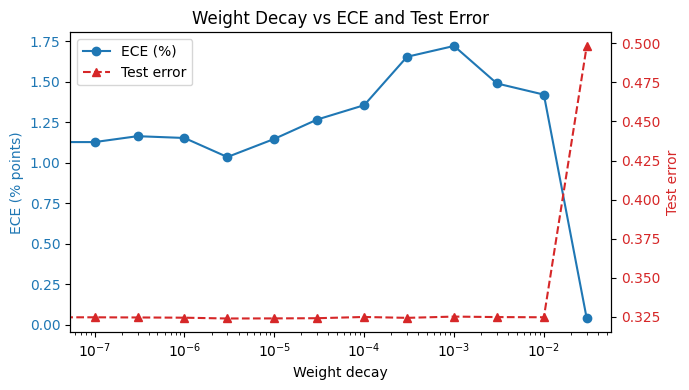

In [13]:
fig, ax1 = plt.subplots(figsize=(7, 4))


ax1.plot(weights,
    ece_vals * 100,
    marker="o",
    color="tab:blue",
    label="ECE (%)")
ax1.set_xlabel("Weight decay")
ax1.set_ylabel("ECE (% points)", color="tab:blue")
ax1.tick_params(axis="y", labelcolor="tab:blue")
ax1.set_xscale("log")

ax2 = ax1.twinx()
ax2.plot(weights,
    err_vals,
    marker="^",
    linestyle="--",
    color="tab:red",
    label="Test error")
ax2.set_ylabel("Test error", color="tab:red")
ax2.tick_params(axis="y", labelcolor="tab:red")

lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc="best")

plt.title("Weight Decay vs ECE and Test Error")
plt.tight_layout()
plt.show()


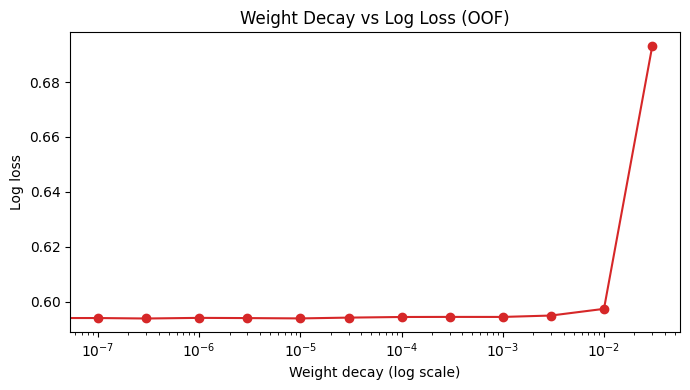

In [14]:
plt.figure(figsize=(7, 4))
plt.plot(
    weights,
    ll_vals,
    marker="o",
    linestyle="-",
    color="tab:red")

plt.xscale("log") 
plt.xlabel("Weight decay (log scale)")
plt.ylabel("Log loss")
plt.title("Weight Decay vs Log Loss (OOF)")
plt.tight_layout()
plt.show()


In [15]:
#batch size grid 
b_size = np.array([30, 50, 70, 90, 110, 130, 150, 170, 190, 210, 230, 250, 270, 290, 310, 330, 350, 370, 390, 410, 430, 450, 470, 490])
ece_vals = []
ll_vals = []
acc_vals = []
err_vals = []

for d in b_size:
    oof = mlp(
        X, y,
        n_splits=5,                       
        n_epochs=study_ll.best_params["n_epochs"],
        batch_size=int(d),
        lr=study_ll.best_params["lr"],
        weight_decay=study_ll.best_params["weight_decay"],
        dropout=study_ll.best_params['dropout'],
        seed=42
    )

    m = ~np.isnan(oof)
    ece = expected_calibration_error(y[m], oof[m], n_bins=10)
    ll = log_loss(y[m], oof[m])
    acc = accuracy_score(y[m], (oof[m] >= 0.5).astype(int))
    err = 1.0 - acc 

    ece_vals.append(ece)
    ll_vals.append(ll)
    acc_vals.append(acc)
    err_vals.append(err)

    print(f"Batch Size={d:.4f} | ECE={ece*100:.4f}% | logloss={ll:.4f} | acc={acc:.4f}")

ece_vals = np.array(ece_vals)
ll_vals = np.array(ll_vals)
acc_vals = np.array(acc_vals)
err_vals = np.array(err_vals)

Batch Size=30.0000 | ECE=1.4820% | logloss=0.5976 | acc=0.6753
Batch Size=50.0000 | ECE=1.0937% | logloss=0.5959 | acc=0.6746
Batch Size=70.0000 | ECE=1.0642% | logloss=0.5953 | acc=0.6762
Batch Size=90.0000 | ECE=0.6870% | logloss=0.5949 | acc=0.6774
Batch Size=110.0000 | ECE=1.0314% | logloss=0.5953 | acc=0.6754
Batch Size=130.0000 | ECE=0.9593% | logloss=0.5954 | acc=0.6751
Batch Size=150.0000 | ECE=0.8369% | logloss=0.5960 | acc=0.6762
Batch Size=170.0000 | ECE=0.9689% | logloss=0.5951 | acc=0.6754
Batch Size=190.0000 | ECE=1.3072% | logloss=0.5954 | acc=0.6751
Batch Size=210.0000 | ECE=0.7728% | logloss=0.5945 | acc=0.6756
Batch Size=230.0000 | ECE=1.1095% | logloss=0.5950 | acc=0.6756
Batch Size=250.0000 | ECE=1.1413% | logloss=0.5941 | acc=0.6762
Batch Size=270.0000 | ECE=1.1286% | logloss=0.5943 | acc=0.6754
Batch Size=290.0000 | ECE=1.2272% | logloss=0.5938 | acc=0.6750
Batch Size=310.0000 | ECE=1.0386% | logloss=0.5939 | acc=0.6747
Batch Size=330.0000 | ECE=1.2002% | logloss=

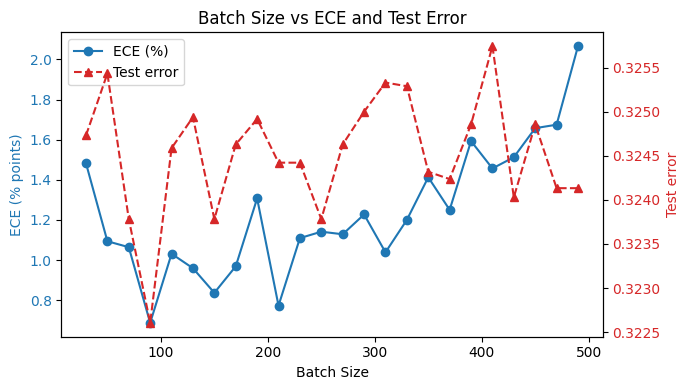

In [16]:
fig, ax1 = plt.subplots(figsize=(7, 4))
ax1.plot(b_size,
    ece_vals * 100,
    marker="o",
    color="tab:blue",
    label="ECE (%)")
ax1.set_xlabel("Batch Size")
ax1.set_ylabel("ECE (% points)", color="tab:blue")
ax1.tick_params(axis="y", labelcolor="tab:blue")

ax2 = ax1.twinx()
ax2.plot(b_size,
    err_vals,
    marker="^",
    linestyle="--",
    color="tab:red",
    label="Test error")
ax2.set_ylabel("Test error", color="tab:red")
ax2.tick_params(axis="y", labelcolor="tab:red")

lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc="best")

plt.title("Batch Size vs ECE and Test Error")
plt.tight_layout()
plt.show()

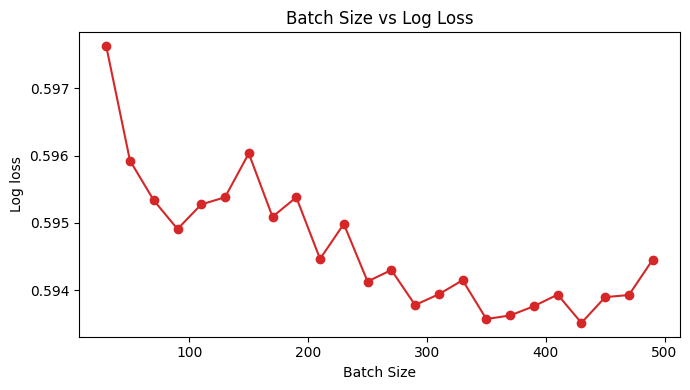

In [17]:
plt.figure(figsize=(7, 4))
plt.plot(
    b_size,
    ll_vals,
    marker="o",
    linestyle="-",
    color="tab:red"
)

plt.xlabel("Batch Size")
plt.ylabel("Log loss")
plt.title("Batch Size vs Log Loss")
plt.tight_layout()
plt.show()


In [18]:


# Epoch Grid
epochs = np.array([3,6,9,12,15,18,21,24,27,30,33,36])
ece_vals = []
ll_vals = []
acc_vals = []
err_vals = []

for d in epochs:
    oof = mlp(
        X, y,
        n_splits=5,                       
        n_epochs=int(d),
        batch_size=study_ll.best_params["batch_size"],
        lr=study_ll.best_params["lr"],
        weight_decay=study_ll.best_params["weight_decay"],
        dropout=study_ll.best_params['dropout'],
        seed=42
    )

    m = ~np.isnan(oof)
    ece = expected_calibration_error(y[m], oof[m], n_bins=10)
    ll = log_loss(y[m], oof[m])
    acc = accuracy_score(y[m], (oof[m] >= 0.5).astype(int))
    err = 1.0 - acc 

    ece_vals.append(ece)
    ll_vals.append(ll)
    acc_vals.append(acc)
    err_vals.append(err)

    print(f"Epoch={d:.4f} | ECE={ece*100:.4f}% | logloss={ll:.4f} | acc={acc:.4f}")

ece_vals = np.array(ece_vals)
ll_vals = np.array(ll_vals)
acc_vals = np.array(acc_vals)
err_vals = np.array(err_vals)

Epoch=3.0000 | ECE=1.7909% | logloss=0.5944 | acc=0.6751
Epoch=6.0000 | ECE=1.3532% | logloss=0.5937 | acc=0.6762
Epoch=9.0000 | ECE=1.4092% | logloss=0.5945 | acc=0.6765
Epoch=12.0000 | ECE=1.2652% | logloss=0.5949 | acc=0.6747
Epoch=15.0000 | ECE=1.5055% | logloss=0.5984 | acc=0.6726
Epoch=18.0000 | ECE=0.8936% | logloss=0.5973 | acc=0.6735
Epoch=21.0000 | ECE=1.0335% | logloss=0.5988 | acc=0.6727
Epoch=24.0000 | ECE=1.9543% | logloss=0.6017 | acc=0.6735
Epoch=27.0000 | ECE=1.5770% | logloss=0.6040 | acc=0.6726
Epoch=30.0000 | ECE=1.2412% | logloss=0.6036 | acc=0.6713
Epoch=33.0000 | ECE=1.1688% | logloss=0.6049 | acc=0.6710
Epoch=36.0000 | ECE=1.1962% | logloss=0.6069 | acc=0.6700


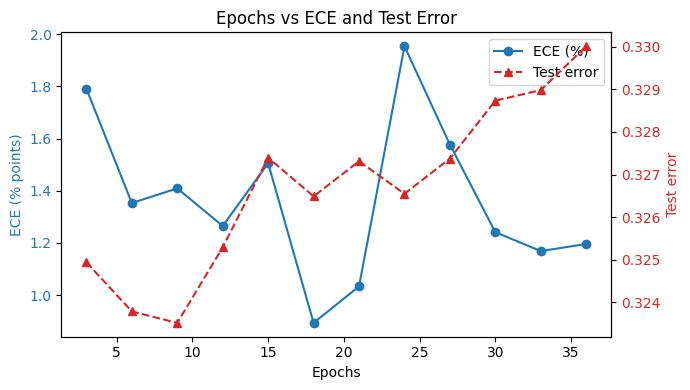

In [19]:
fig, ax1 = plt.subplots(figsize=(7, 4))

ax1.plot(epochs,
    ece_vals * 100,
    marker="o",
    color="tab:blue",
    label="ECE (%)")
ax1.set_xlabel("Epochs")
ax1.set_ylabel("ECE (% points)", color="tab:blue")
ax1.tick_params(axis="y", labelcolor="tab:blue")

ax2 = ax1.twinx()
ax2.plot(epochs,
    err_vals,
    marker="^",
    linestyle="--",
    color="tab:red",
    label="Test error")
ax2.set_ylabel("Test error", color="tab:red")
ax2.tick_params(axis="y", labelcolor="tab:red")

lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc="best")

plt.title("Epochs vs ECE and Test Error")
plt.tight_layout()
plt.show()

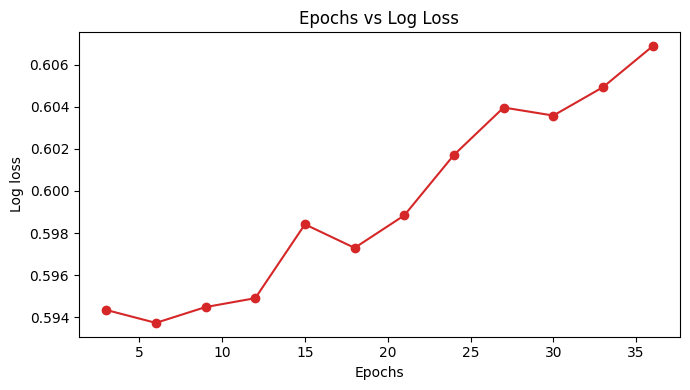

In [20]:
plt.figure(figsize=(7, 4))
plt.plot(
    epochs,
    ll_vals,
    marker="o",
    linestyle="-",
    color="tab:red"
)

plt.xlabel("Epochs")
plt.ylabel("Log loss")
plt.title("Epochs vs Log Loss")
plt.tight_layout()
plt.show()

# Platt and Temp Scaling

In [21]:

# Temp scal module and function
class TemperatureScaler(nn.Module):
    def __init__(self):
        super().__init__()
        self.log_T = nn.Parameter(torch.zeros(1))  

    def forward(self, logits):
        return logits / torch.exp(self.log_T)


def temp_scale_logits(train_logits, train_y, test_logits, max_iter=50):
    scaler = TemperatureScaler()
    optimizer = torch.optim.LBFGS(scaler.parameters(), lr=0.1, max_iter=max_iter)
    criterion = nn.BCEWithLogitsLoss()

    train_logits_t = torch.tensor(train_logits, dtype=torch.float32)
    train_y_t = torch.tensor(train_y, dtype=torch.float32)

    def closure():
        optimizer.zero_grad()
        loss = criterion(scaler(train_logits_t), train_y_t)
        loss.backward()
        return loss

    optimizer.step(closure)

    with torch.no_grad():
        scaled_logits = scaler(torch.tensor(test_logits, dtype=torch.float32)).numpy()

    return scaled_logits


def sigmoid_np(z):
    return 1.0 / (1.0 + np.exp(-z))

def calibrate_oof_logits(oof_logits, y, method="temp", n_splits=5):
    tscv = TimeSeriesSplit(n_splits=n_splits)
    oof_cal = np.full(len(y), np.nan, dtype=float)

    for train_idx, test_idx in tscv.split(oof_logits):
        train_logits = oof_logits[train_idx]
        train_y      = y[train_idx]
        test_logits  = oof_logits[test_idx]

        test_mask = ~np.isnan(test_logits)
        if not np.any(test_mask):
            continue
        base_probs = sigmoid_np(test_logits)
        train_mask = ~np.isnan(train_logits)
        train_logits_valid = train_logits[train_mask]
        train_y_valid      = train_y[train_mask]
        if len(train_logits_valid) < 10:
            oof_cal[test_idx] = base_probs
            continue
        test_logits_valid = test_logits[test_mask]

        if method == "temp":
            scaled_logits = temp_scale_logits(train_logits_valid, train_y_valid, test_logits_valid)
            probs_valid = sigmoid_np(scaled_logits)

        elif method == "platt":
            lr = LogisticRegression(solver="lbfgs", max_iter=1000)
            lr.fit(train_logits_valid.reshape(-1, 1), train_y_valid)
            probs_valid = lr.predict_proba(test_logits_valid.reshape(-1, 1))[:, 1]

        probs_out = base_probs.copy()
        probs_out[test_mask] = probs_valid
        oof_cal[test_idx] = probs_out

    return oof_cal


In [22]:
# Log-loss tuned MLP
oof_probs_ll_temp  = calibrate_oof_logits(logit_ll,  y, method="temp",  n_splits=5)
oof_probs_ll_platt = calibrate_oof_logits(logit_ll,  y, method="platt", n_splits=5)

# Error-rate tuned MLP
oof_probs_err_temp  = calibrate_oof_logits(logit_err, y, method="temp",  n_splits=5)
oof_probs_err_platt = calibrate_oof_logits(logit_err, y, method="platt", n_splits=5)


In [23]:
def results(y, probs, name, n_bins=10):
    m = ~np.isnan(probs)
    ll = log_loss(y[m], probs[m])
    acc = accuracy_score(y[m], (probs[m] >= 0.5).astype(int))
    err = 1.0 - acc
    ece = expected_calibration_error(y[m], probs[m], n_bins=n_bins)

    print(f"{name}")
    print(f"Coverage: {mask.mean():.3f} | NaNs: {np.isnan(probs).sum()} / {len(probs)}")
    print(f"Log loss: {ll:.6f} | Acc: {acc:.6f} | Err: {err:.6f} | ECE: {ece:.6f} ({ece*100:.2f}%)")

    reliability_diagram(y[mask], probs[mask], n_bins=n_bins, title=f"{name} — Test Calibration")

    return {"Model": name, "LogLoss": ll, "Accuracy": acc, "Error": err, "ECE": ece, "ECE_%": ece*100}


MLP-LL
Coverage: 0.833 | NaNs: 9688 / 58128
Log loss: 0.593876 | Acc: 0.676012 | Err: 0.323988 | ECE: 0.011131 (1.11%)


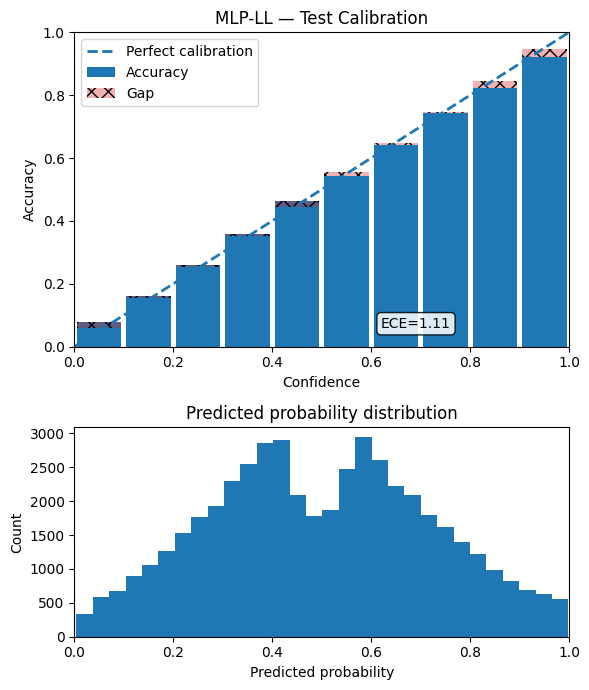

MLP-LL + Temperature
Coverage: 0.833 | NaNs: 9688 / 58128
Log loss: 0.593703 | Acc: 0.676012 | Err: 0.323988 | ECE: 0.007426 (0.74%)


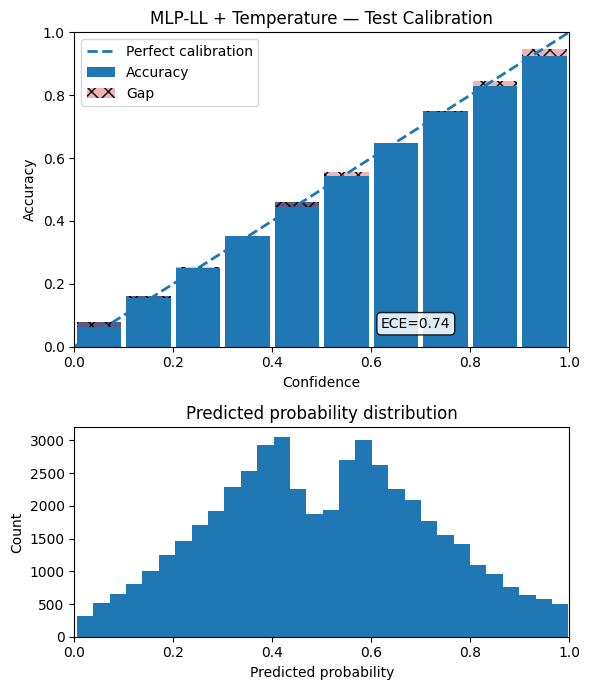

MLP-LL + Platt
Coverage: 0.833 | NaNs: 9688 / 58128
Log loss: 0.594138 | Acc: 0.675619 | Err: 0.324381 | ECE: 0.008683 (0.87%)


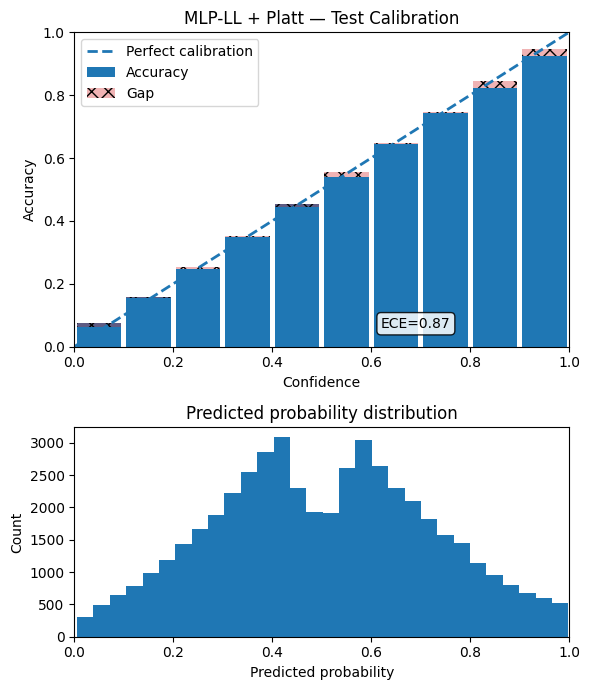

MLP-ERR
Coverage: 0.833 | NaNs: 9688 / 58128
Log loss: 0.593598 | Acc: 0.676445 | Err: 0.323555 | ECE: 0.017890 (1.79%)


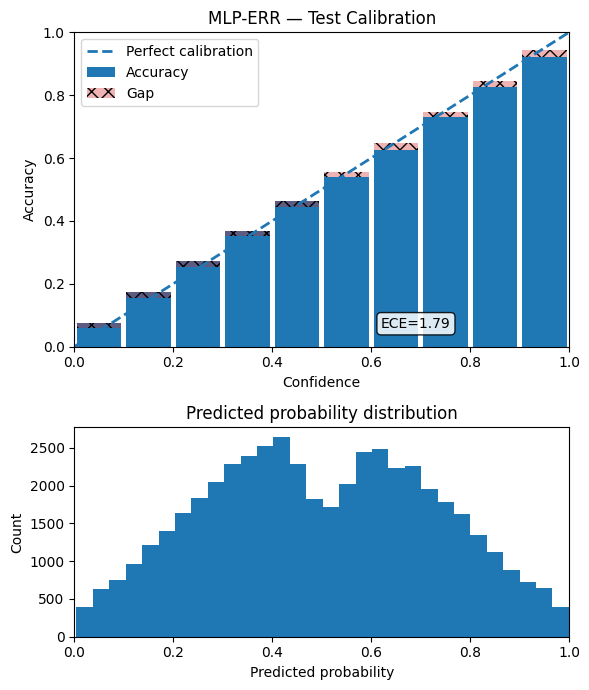

MLP-ERR + Temperature
Coverage: 0.833 | NaNs: 9688 / 58128
Log loss: 0.593274 | Acc: 0.676445 | Err: 0.323555 | ECE: 0.005138 (0.51%)


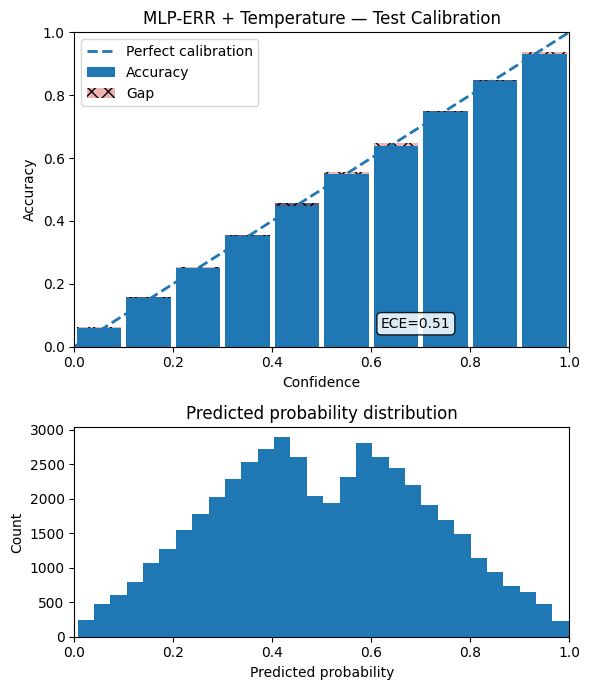

MLP-ERR + Platt
Coverage: 0.833 | NaNs: 9688 / 58128
Log loss: 0.593302 | Acc: 0.676404 | Err: 0.323596 | ECE: 0.005168 (0.52%)


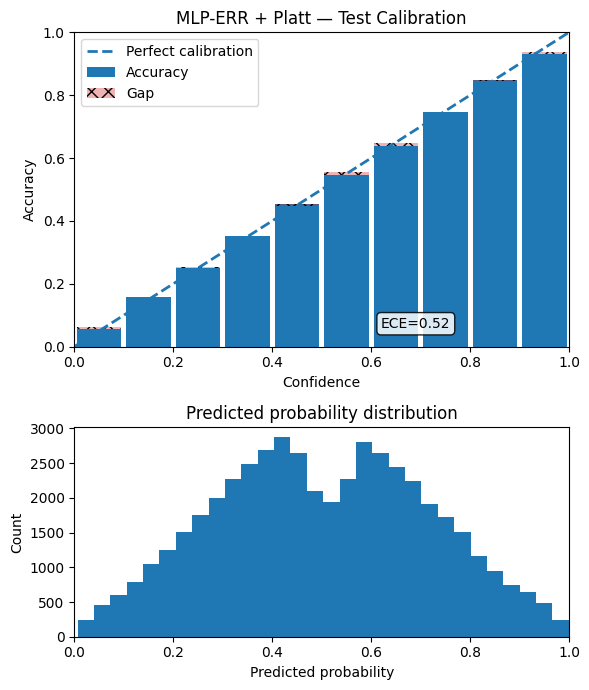

,Model,LogLoss,Accuracy,Error,ECE,ECE_%
4,MLP-ERR + Temperature,0.593274,0.676445,0.323555,0.005138,0.513821
5,MLP-ERR + Platt,0.593302,0.676404,0.323596,0.005168,0.516850
3,MLP-ERR,0.593598,0.676445,0.323555,0.017890,1.788962
1,MLP-LL + Temperature,0.593703,0.676012,0.323988,0.007426,0.742568
0,MLP-LL,0.593876,0.676012,0.323988,0.011131,1.113147
2,MLP-LL + Platt,0.594138,0.675619,0.324381,0.008683,0.868257


In [24]:
rows = []

rows.append(results(y, oof_ll,"MLP-LL", n_bins=10))
rows.append(results(y, oof_probs_ll_temp,"MLP-LL + Temperature",n_bins=10))
rows.append(results(y, oof_probs_ll_platt,"MLP-LL + Platt", n_bins=10))

rows.append(results(y, oof_err,"MLP-ERR", n_bins=10))
rows.append(results(y, oof_probs_err_temp,"MLP-ERR + Temperature",  n_bins=10))
rows.append(results(y, oof_probs_err_platt, "MLP-ERR + Platt",n_bins=10))

results_df = pd.DataFrame(rows).sort_values("LogLoss")
results_df
